In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import parser
import seaborn as sns
from scipy.stats import norm
from scipy.stats import genextreme as gev
from scipy.stats import pareto 
from scipy import stats
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import random
import censusdata


# Import Supporting Shape Files

In [2]:
#import boston block groups

blockgroup20_BOS = gpd.read_file('../Data/Census2020_BlockGroups/Census2020_BlockGroups.shp')
#exclude islands
blockgroup20_BOS = blockgroup20_BOS[blockgroup20_BOS['GEOID20'] != '250259801011']
blockgroup20_BOS = blockgroup20_BOS.to_crs('epsg:4326')
blockgroup20_BOS.head()

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,Shape_STAr,Shape_STLe,geometry
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,413598.0,+42.3833695,-071.0707743,1.807118e+07,29256.866068,"POLYGON ((-71.08097 42.38232, -71.08095 42.382..."
1,2,25,025,051101,1,250250511011,Block Group 1,G5030,S,220626.0,0.0,+42.3882285,-071.0046816,2.374654e+06,9142.174252,"POLYGON ((-71.01084 42.38613, -71.00891 42.386..."
2,3,25,025,051101,4,250250511014,Block Group 4,G5030,S,227071.0,270.0,+42.3913407,-071.0020343,2.446949e+06,11579.546171,"POLYGON ((-71.00629 42.39098, -71.00628 42.391..."
3,4,25,025,981600,1,250259816001,Block Group 1,G5030,S,586981.0,158777.0,+42.3886205,-070.9934424,8.026752e+06,16626.718823,"POLYGON ((-71.00113 42.38710, -71.00100 42.387..."
4,5,25,025,010204,3,250250102043,Block Group 3,G5030,S,145888.0,0.0,+42.3459611,-071.1020344,1.570220e+06,5510.560013,"POLYGON ((-71.10507 42.34670, -71.10457 42.346..."


In [3]:
blockgroup10_BOS = gpd.read_file('../Data/CBG_Boston_2010_BARI/Census Block Groups.shp')
blockgroup10_BOS['TRACT'] = blockgroup10_BOS['GEOID10'].astype(str).str[5:-1]
blockgroup10_BOS['BLKGRP'] = 'Block Group '+blockgroup10_BOS['GEOID10'].astype(str).str[-1]
blockgroup10_BOS.head()

,OBJECTID,GEOID10,ALAND10,AWATER10,POP100,HU100,Type,Res,BG_ID_10,CT_ID_10,...,WARD,ISD_Nbhd,Police_Dis,Fire_Distr,PWD,Shape_Leng,Shape_Area,geometry,TRACT,BLKGRP
0,1,250250101031,101211.0,0.0,2111.0,309.0,I,0.0,250250101031,25025010103,...,21.0,Fenway/Kenmore,4.0,4.0,1-10A: Kenmore/Fenway/Mission Hill,0.020754,0.000011,"POLYGON ((-71.10520 42.34844, -71.10682 42.348...",010103,Block Group 1
1,2,250250104053,39125.0,0.0,626.0,355.0,I,0.0,250250104053,25025010405,...,4.0,Fenway/Kenmore,4.0,4.0,1-10A: Kenmore/Fenway/Mission Hill,0.008288,0.000004,"POLYGON ((-71.08350 42.34126, -71.08431 42.340...",010405,Block Group 3
2,3,250250102033,67710.0,0.0,1563.0,1078.0,I,0.0,250250102033,25025010203,...,5.0,Fenway/Kenmore,4.0,4.0,1-10A: Kenmore/Fenway/Mission Hill,0.012436,0.000007,"POLYGON ((-71.09841 42.34079, -71.09863 42.340...",010203,Block Group 3
3,4,250250102032,115062.0,0.0,2369.0,1526.0,I,0.0,250250102032,25025010203,...,5.0,Fenway/Kenmore,4.0,4.0,1-10A: Kenmore/Fenway/Mission Hill,0.015750,0.000013,"POLYGON ((-71.10252 42.34337, -71.10242 42.343...",010203,Block Group 2
4,5,250250102041,39843.0,0.0,1098.0,287.0,I,0.0,250250102041,25025010204,...,21.0,Fenway/Kenmore,4.0,4.0,1-10A: Kenmore/Fenway/Mission Hill,0.012847,0.000004,"POLYGON ((-71.10520 42.34844, -71.10468 42.348...",010204,Block Group 1


In [4]:
blockgroup10_BOS.columns

Index(['OBJECTID', 'GEOID10', 'ALAND10', 'AWATER10', 'POP100', 'HU100', 'Type',
       'Res', 'BG_ID_10', 'CT_ID_10', 'BOSNA_R_ID', 'NSA_NAME', 'BRA_PD_ID',
       'BRA_PD', 'ZIPCODE', 'City_Counc', 'WARD', 'ISD_Nbhd', 'Police_Dis',
       'Fire_Distr', 'PWD', 'Shape_Leng', 'Shape_Area', 'geometry', 'TRACT',
       'BLKGRP'],
      dtype='object')

In [5]:
#import NY state block groups and filter to only NYC counties
nyc_counties = ['047', '005','081','085','061']

blockgroup20_NY = gpd.read_file('../Data/cb_2021_36_bg_500k/cb_2021_36_bg_500k.shp')
#blockgroup20_NY = blockgroup20_NY.to_crs('epsg:4326')
blockgroup20_NY = blockgroup20_NY[(blockgroup20_NY['COUNTYFP'].isin(nyc_counties)) & (blockgroup20_NY['ALAND'] != 0)]
blockgroup20_NY.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,geometry
0,36,081,093401,2,1500000US360810934012,360810934012,2,Block Group 2,BG,132716,0,"POLYGON ((-73.84400 40.57951, -73.84305 40.577..."
2,36,005,051601,2,1500000US360050516012,360050516012,2,Block Group 2,BG,256313,0,"POLYGON ((-73.79188 40.85522, -73.78743 40.849..."
5,36,061,015001,1,1500000US360610150011,360610150011,1,Block Group 1,BG,25990,0,"POLYGON ((-73.95881 40.78086, -73.95720 40.780..."
7,36,047,033300,1,1500000US360470333001,360470333001,1,Block Group 1,BG,46523,0,"POLYGON ((-73.94244 40.66673, -73.93968 40.666..."
8,36,061,008900,3,1500000US360610089003,360610089003,3,Block Group 3,BG,40799,0,"POLYGON ((-74.00553 40.74582, -74.00269 40.744..."


# Find Relevant Race Data Sets and Geography Codes for Bos & NYC

In [6]:
race_columns = []
for i in range(1,9):
    race_columns.append('B02001_00{}E'.format(i))

print(race_columns)

hispanic_race_columns = []

for i in range(1,13):
    if i == 2 or i == 10 or i == 11:
        pass
    elif i <10:
        hispanic_race_columns.append('B03002_00{}E'.format(i))
    else:
        hispanic_race_columns.append('B03002_0{}E'.format(i))

print(hispanic_race_columns)


column_vals = ['Total','White', 'Black or African American','American Indian and Alaska Native', 'Asain',\
               'Native Hawaiian and Other Pacific Islander', 'Some other race alone', 'Two or More Races']

hisp_col_vals = ['Total'] + [item+', not hispanic' for item in column_vals[1:]] +['Hispanic or Latino']
print(hisp_col_vals)

col_dict = {race_columns[i]: column_vals[i] for i in range(len(column_vals))}
col_ethnicity_dict = {hispanic_race_columns[i]: hisp_col_vals[i] for i in range(len(hisp_col_vals))}


['B02001_001E', 'B02001_002E', 'B02001_003E', 'B02001_004E', 'B02001_005E', 'B02001_006E', 'B02001_007E', 'B02001_008E']
['B03002_001E', 'B03002_003E', 'B03002_004E', 'B03002_005E', 'B03002_006E', 'B03002_007E', 'B03002_008E', 'B03002_009E', 'B03002_012E']
['Total', 'White, not hispanic', 'Black or African American, not hispanic', 'American Indian and Alaska Native, not hispanic', 'Asain, not hispanic', 'Native Hawaiian and Other Pacific Islander, not hispanic', 'Some other race alone, not hispanic', 'Two or More Races, not hispanic', 'Hispanic or Latino']


In [7]:
states = censusdata.geographies(censusdata.censusgeo([('state', '*')]), 'acs5', 2020)
print(states['New York'], states['Massachusetts'])

boscounties = censusdata.geographies(censusdata.censusgeo([('state', '25'), ('county', '*')]), 'acs5', 2020)
print(boscounties['Suffolk County, Massachusetts'])


nyccounties = censusdata.geographies(censusdata.censusgeo([('state', '36'), ('county', '*')]), 'acs5', 2020)
print(nyccounties["Kings County, New York"], nyccounties["Bronx County, New York"],\
      nyccounties["Queens County, New York"], nyccounties["Richmond County, New York"], nyccounties["New York County, New York"])

Summary level: 040, state:36 Summary level: 040, state:25
Summary level: 050, state:25> county:025
Summary level: 050, state:36> county:047 Summary level: 050, state:36> county:005 Summary level: 050, state:36> county:081 Summary level: 050, state:36> county:085 Summary level: 050, state:36> county:061


In [8]:
def get_acs5_data(yr,stateid,countyid,column_ls,col_dict):

    df = censusdata.download('acs5', yr,
               censusdata.censusgeo([('state', stateid),
                                     ('county', countyid),
                                     ('block group', '*')]),
                                      column_ls)
    df.reset_index(inplace=True)
    df['index'] = df['index'].astype('str')
    
    Block_Group = []
    tract = []
    for index, row in df.iterrows():
        Block_Group.append(row['index'][:13])
        tract.append(row['index'][-21:-15])

    df['Block Group'] = Block_Group
    df['Tract'] = tract
    
    df = df.rename(columns = col_dict)
    
    return df

In [9]:
acs_yrls = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009]

for yr in acs_yrls:
    try:
        bos_ethnicity = get_acs5_data(yr,'25','025',hispanic_race_columns,col_ethnicity_dict)
        print(len(bos_ethnicity))
        print('Successfully retreived data from: '+str(yr))
    except:
        print('Unsuccessfully retreived data from: '+str(yr))
        pass

681
Successfully retreived data from: 2020
646
Successfully retreived data from: 2019
646
Successfully retreived data from: 2018
646
Successfully retreived data from: 2017
646
Successfully retreived data from: 2016
646
Successfully retreived data from: 2015
646
Successfully retreived data from: 2014
646
Successfully retreived data from: 2013
Unsuccessfully retreived data from: 2012
Unsuccessfully retreived data from: 2011
Unsuccessfully retreived data from: 2010
631
Successfully retreived data from: 2009


In [10]:
for yr in acs_yrls:
    try:
        nyc_ethnicity = get_acs5_data(yr,'36',nyc_counties[0],hispanic_race_columns,col_ethnicity_dict)

        for county in nyc_counties[1:]:
            nyc_ethnicity = nyc_ethnicity.append(get_acs5_data(yr,'36',county,hispanic_race_columns,col_ethnicity_dict))
        
        print(len(nyc_ethnicity))
        print('Successfully retreived data from: '+str(yr))
   
    except:
        print('Unsuccessfully retreived data from: '+str(yr))
        pass 

6807
Successfully retreived data from: 2020
6493
Successfully retreived data from: 2019
6493
Successfully retreived data from: 2018
6493
Successfully retreived data from: 2017
6493
Successfully retreived data from: 2016
6493
Successfully retreived data from: 2015
6493
Successfully retreived data from: 2014
6493
Successfully retreived data from: 2013
Unsuccessfully retreived data from: 2012
Unsuccessfully retreived data from: 2011
Unsuccessfully retreived data from: 2010
5733
Successfully retreived data from: 2009


Based on the outputs above, we will do our temporal analysis from 2013-2020. It also looks like there was redistricting in 2020 for both cities. This will require us to find two seperate block group shape files

# Join to ethnicity tbl to shapefiles

## Boston

In [21]:
bos_ethnicity = get_acs5_data(2020,'25','025',hispanic_race_columns,col_ethnicity_dict) 
#bos_ethnicity = get_acs5_data(2019,'25','025',hispanic_race_columns,col_ethnicity_dict) 
bos_ethnicity.head()

,index,Total,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,Block Group,Tract
0,"Block Group 3, Census Tract 1304.02, Suffolk C...",732,491,0,0,46,0,0,12,183,Block Group 3,130402
1,"Block Group 2, Census Tract 1304.04, Suffolk C...",940,752,24,0,99,0,0,9,56,Block Group 2,130404
2,"Block Group 3, Census Tract 1304.06, Suffolk C...",390,214,95,0,0,0,0,0,81,Block Group 3,130406
3,"Block Group 1, Census Tract 1403, Suffolk Coun...",1172,54,422,0,0,0,0,0,696,Block Group 1,140300
4,"Block Group 4, Census Tract 1403, Suffolk Coun...",1006,204,766,0,0,0,0,0,36,Block Group 4,140300


In [22]:
acs5_blockgroup_BOS = blockgroup20_BOS.merge(bos_ethnicity, how = 'left', left_on = ['TRACTCE20','NAMELSAD20'], right_on = ['Tract','Block Group'])
#acs5_blockgroup_BOS = blockgroup10_BOS.merge(bos_ethnicity, how = 'left', left_on = ['TRACT','BLKGRP'], right_on = ['Tract','Block Group'])

acs5_blockgroup_BOS.head()

,OBJECTID,STATEFP20,COUNTYFP20,TRACTCE20,BLKGRPCE20,GEOID20,NAMELSAD20,MTFCC20,FUNCSTAT20,ALAND20,...,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,Block Group,Tract
0,1,25,025,040600,1,250250406001,Block Group 1,G5030,S,1265377.0,...,1086,165,0,102,0,0,25,101,Block Group 1,040600
1,2,25,025,051101,1,250250511011,Block Group 1,G5030,S,220626.0,...,956,162,0,82,0,0,0,1191,Block Group 1,051101
2,3,25,025,051101,4,250250511014,Block Group 4,G5030,S,227071.0,...,326,26,0,18,0,0,0,649,Block Group 4,051101
3,4,25,025,981600,1,250259816001,Block Group 1,G5030,S,586981.0,...,0,0,0,0,0,0,0,0,Block Group 1,981600
4,5,25,025,010204,3,250250102043,Block Group 3,G5030,S,145888.0,...,465,34,0,201,0,0,15,56,Block Group 3,010204


<AxesSubplot:>

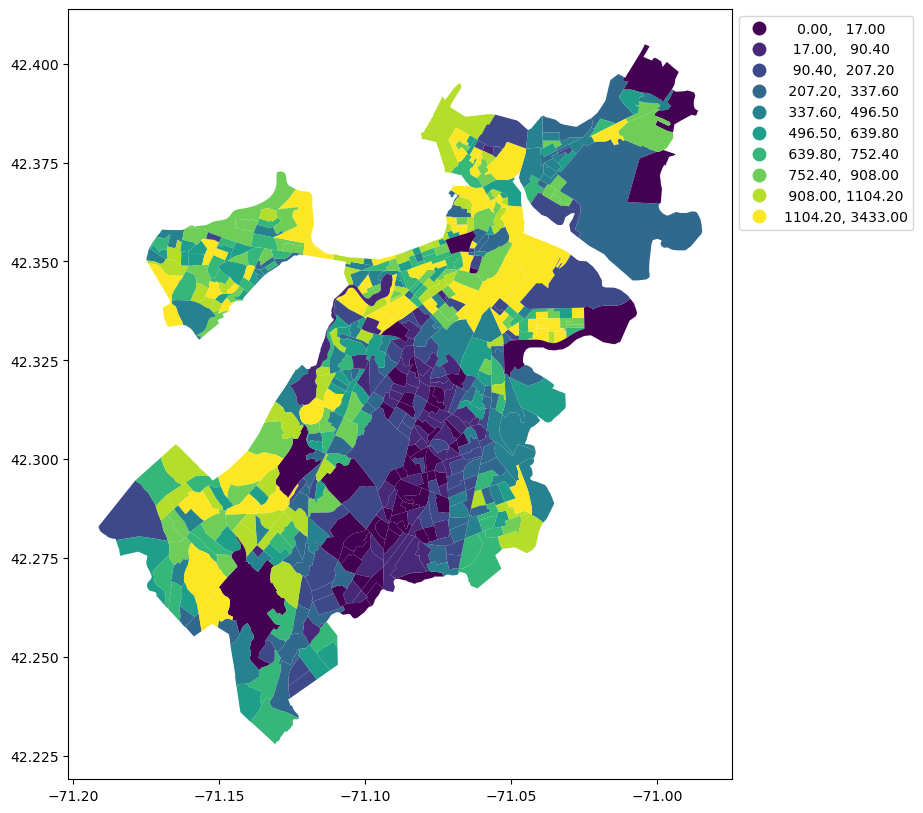

In [13]:
acs5_blockgroup_BOS.plot(column = 'White, not hispanic', k=10, scheme='Quantiles',legend=True, figsize = (10,10)
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

## NYC

<AxesSubplot:>

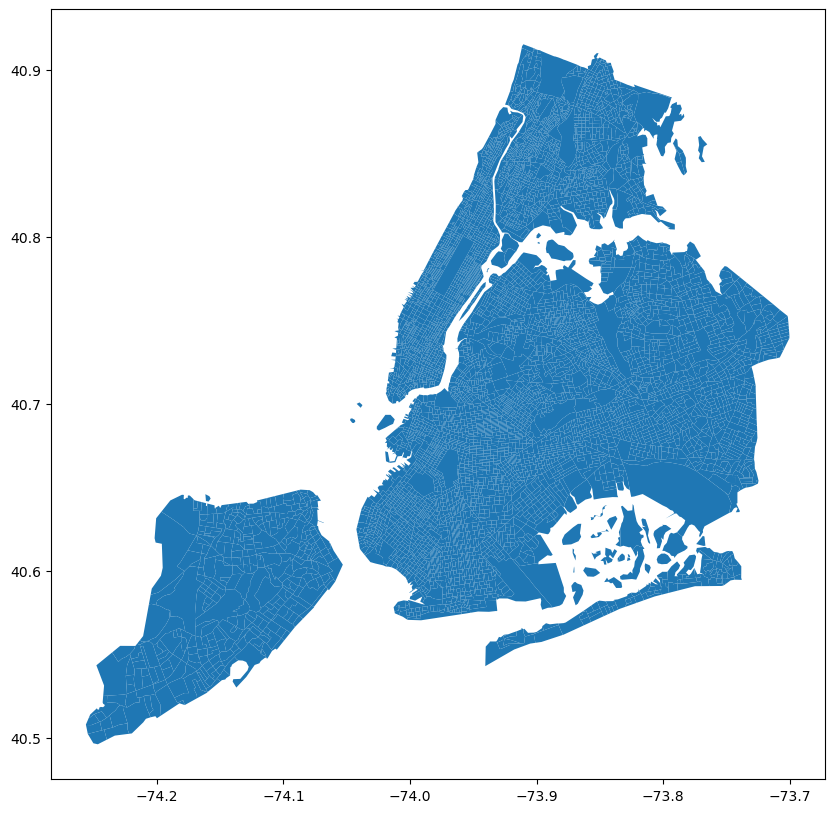

In [14]:
blockgroup20_NY.plot(figsize = (10,10))

In [15]:
blockgroup20_NY.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [16]:
nyc_ethnicity = get_acs5_data(2020,'36',nyc_counties[0],hispanic_race_columns,col_ethnicity_dict)

for county in nyc_counties[1:]:
    nyc_ethnicity = nyc_ethnicity.append(get_acs5_data(2020,'36',county,hispanic_race_columns,col_ethnicity_dict))   
    print(len(nyc_ethnicity))

acs5_blockgroup_NY = blockgroup20_NY.merge(nyc_ethnicity, how = 'left', left_on = ['TRACTCE','NAMELSAD'], right_on = ['Tract','Block Group'])

acs5_blockgroup_NY.head()

3338
5141
5515
6807


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,...,"White, not hispanic","Black or African American, not hispanic","American Indian and Alaska Native, not hispanic","Asain, not hispanic","Native Hawaiian and Other Pacific Islander, not hispanic","Some other race alone, not hispanic","Two or More Races, not hispanic",Hispanic or Latino,Block Group,Tract
0,36,081,093401,2,1500000US360810934012,360810934012,2,Block Group 2,BG,132716,...,875,48,0,13,0,0,2,140,Block Group 2,093401
1,36,005,051601,2,1500000US360050516012,360050516012,2,Block Group 2,BG,256313,...,120,828,0,0,0,0,112,159,Block Group 2,051601
2,36,005,051601,2,1500000US360050516012,360050516012,2,Block Group 2,BG,256313,...,684,0,0,0,0,0,0,118,Block Group 2,051601
3,36,061,015001,1,1500000US360610150011,360610150011,1,Block Group 1,BG,25990,...,995,0,0,194,0,0,0,49,Block Group 1,015001
4,36,047,033300,1,1500000US360470333001,360470333001,1,Block Group 1,BG,46523,...,325,367,17,10,0,0,30,20,Block Group 1,033300


<AxesSubplot:>

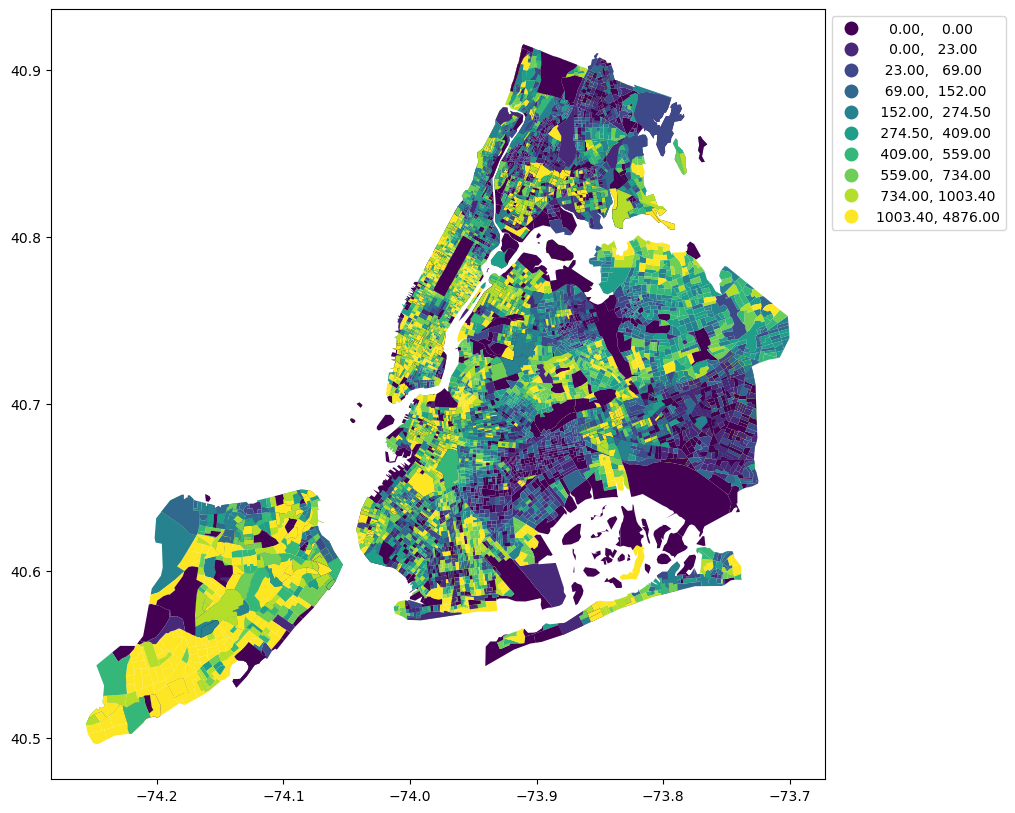

In [17]:
acs5_blockgroup_NY.plot(column = 'White, not hispanic', k=10, scheme='Quantiles',
                        markersize=0.01,figsize=(10,10),legend = True,
                        missing_kwds={"color": "lightgrey", ## what to do with missing values
                                         "edgecolor": "red",
                                        "hatch": "///",
                                        "label": "Missing values",}
                            ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

# Racial Dot Maps

In [18]:
seed = 10
s = np.random.RandomState(seed) if seed else np.random.RandomState(seed)
from random import uniform

def gen_random_points_poly(poly, num_points):
    
    """
    Returns a list of N randomly generated points within a polygon.
    """

    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    i=0
    while len(points) < num_points:
        random_point = Point([uniform(min_x, max_x), uniform(min_y, max_y)])
        if random_point.within(poly):
            points.append(random_point)
            i+=1
    return points
def gen_points_in_gdf_polys(geometry, values, points_per_value = None):
    """
    Take a GeoSeries of Polygons along with a Series of values and returns randomly generated points within
    these polygons. Optionally takes a "points_per_value" integer which indicates the number of points that
    should be generated for each 1 value.
    """
    if points_per_value:
        new_values = round(values/points_per_value).astype(int)
    else:
        new_values = values

    new_values = new_values[new_values>0]

    if(new_values.size > 0):
         
        g = gpd.GeoDataFrame(data = {'vals':new_values}, geometry = geometry)

        a = g.apply(lambda row: tuple(gen_random_points_poly(row['geometry'], row['vals'])),1)
        b = gpd.GeoSeries(a.apply(pd.Series).stack(), crs = geometry.crs)
        b.name='geometry'
        
    else:
        g = gpd.GeoDataFrame(data = {'vals':new_values*0}, geometry = geometry)

        a = g.apply(lambda row: tuple(gen_random_points_poly(row['geometry'], row['vals'])),1)
        b = gpd.GeoSeries(a.apply(pd.Series).stack(), crs = geometry.crs)
        b.name='geometry'
    
    return b

In [19]:
s = acs5_blockgroup_BOS[hisp_col_vals].sum().sort_values(ascending=False)
race_ordered_ls = s.index[1:].to_list()
print(race_ordered_ls)

['White, not hispanic', 'Black or African American, not hispanic', 'Hispanic or Latino', 'Asain, not hispanic', 'Two or More Races, not hispanic', 'Some other race alone, not hispanic', 'American Indian and Alaska Native, not hispanic', 'Native Hawaiian and Other Pacific Islander, not hispanic']


2020


KeyboardInterrupt: 

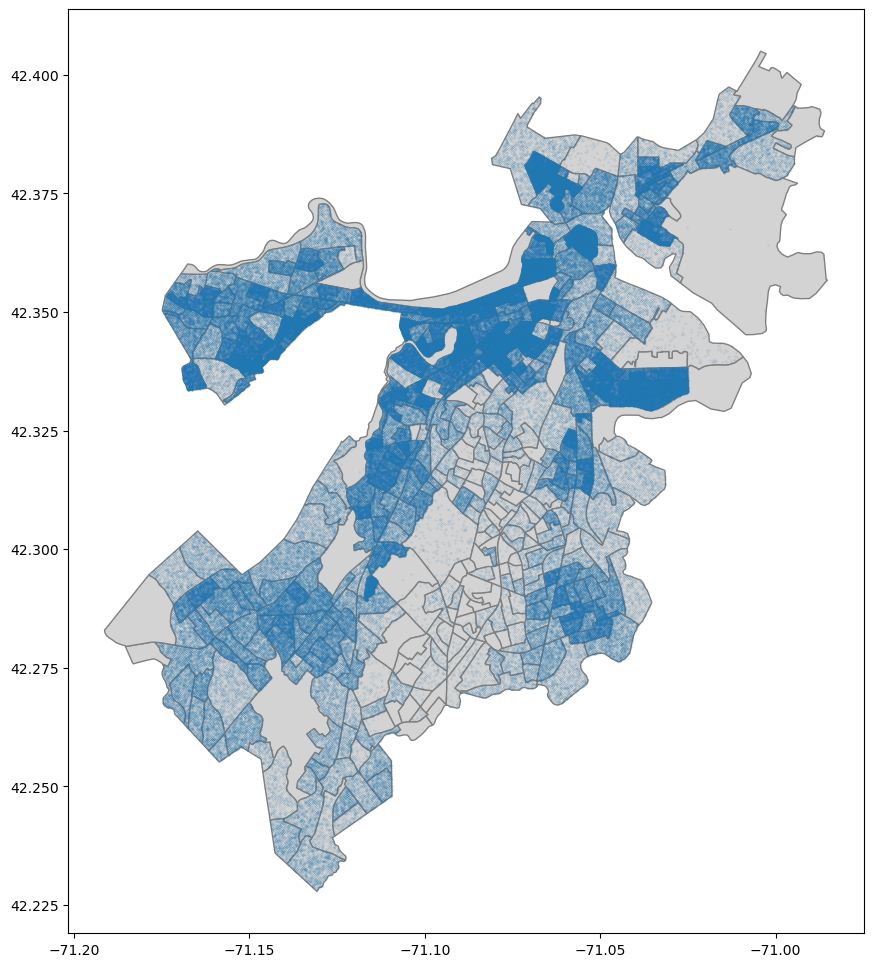

In [20]:
acs_yrls = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]

for yr in acs_yrls:
    #get ACS Data
    print(yr)
    bos_ethnicity = get_acs5_data(yr,'25','025',hispanic_race_columns,col_ethnicity_dict)
    
    #join to census block shape file
    if yr == 2020:   
        acs5_blockgroup_BOS = blockgroup20_BOS.merge(bos_ethnicity, how = 'left', left_on = ['TRACTCE20','NAMELSAD20'], right_on = ['Tract','Block Group'])
        
    else:
        acs5_blockgroup_BOS = blockgroup10_BOS.merge(bos_ethnicity, how = 'left', left_on = ['TRACT','BLKGRP'], right_on = ['Tract','Block Group'])

    #get order of races from most to least populated
    s = acs5_blockgroup_BOS[hisp_col_vals].sum().sort_values(ascending=False)
    race_ordered_ls = s.index[1:].to_list()
    
    #create dot map
    df = pd.DataFrame()

    fig, ax = plt.subplots(figsize=(12,12))

    blockgroup20_BOS.plot(ax=ax, color = 'lightgrey', edgecolor='grey')
    for race in race_ordered_ls:
        #print(race)
        df[race] = gen_points_in_gdf_polys(acs5_blockgroup_BOS['geometry'],acs5_blockgroup_BOS[race]) 
        gen_points_in_gdf_polys(acs5_blockgroup_BOS['geometry'],acs5_blockgroup_BOS[race]).plot(ax=ax, markersize = 0.01,alpha = 0.75, label = race)
        #ax.legend(race)
    ax.set_title(f'Racial Dot Map: Boston {yr}', fontsize=20)
    ax.legend(markerscale = 40)
    fig.patch.set_visible(False)
    ax.axis('off')
    plt.tight_layout()
    fig.savefig(f'../Outputs/{yr}BostonDotMap.jpeg',bbox_inches = 'tight')

In [ ]:
acs_yrls = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]
acs_yrls.reverse()
print(acs_yrls)

In [ ]:
#make gif
import matplotlib.animation as animation

# Create new figure for GIF
fig, ax = plt.subplots(figsize = (10,10))

# Adjust figure so GIF does not have extra whitespace
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.axis('off')
ims = []

acs_yrls = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]
acs_yrls.reverse()

for yr in acs_yrls:
    im = ax.imshow(plt.imread(f'../Outputs/{yr}BostonDotMap.jpeg'), animated = True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=1000)
ani.save('../Outputs/BOS_racialdotmap13_20.gif')

# Contingency Table & Shannon Diversity Index

In [ ]:
geo_col_name = [col for col in acs5_blockgroup_BOS.columns.to_list() if col.find('GEOID') == 0][0]
print(geo_col_name)

In [ ]:
def get_diversity_index(df, race_cols):
    
    geo_col_name = [col for col in df.columns.to_list() if col.find('GEOID') == 0][0]
    cont_tbl = df[[geo_col_name]+race_cols]
    cont_tbl.set_index(geo_col_name, inplace = True)
    
    cont_tbl['Total in Block Group'] = cont_tbl.sum(axis = 'columns')
    #drop any rows with zero total population in block group
    cont_tbl = cont_tbl[cont_tbl['Total in Block Group'] > 25]
    #compute city averages
    tot_race = cont_tbl.sum(axis = 'index')
    perc_race = tot_race / tot_race.sum()
    H_x_avg = -((perc_race*np.log(perc_race)).sum())
    
    
    cols = cont_tbl.columns.to_list()
    H_x = []
    evenness = []

    for index, row in cont_tbl.iterrows():
        perc_race = np.array(row[cols[:-1]])/row[cols[-1]]
        H = -(np.nansum(perc_race*np.log(perc_race)))
        even = H/np.log(len(cols[:-1]))
        H_x.append(H)
        evenness.append(even)

    cont_tbl['H_x'] = H_x
    cont_tbl['Evenness'] = evenness
    
    return H_x_avg, cont_tbl[['Total in Block Group','H_x','Evenness']]


In [ ]:
acs_yrls = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]

for yr in acs_yrls:
    #get ACS Data
    print(yr)
    bos_ethnicity = get_acs5_data(yr,'25','025',hispanic_race_columns,col_ethnicity_dict)
    
    #join to census block shape file
    if yr == 2020:   
        acs5_blockgroup_BOS = blockgroup20_BOS.merge(bos_ethnicity, how = 'left',\
                                                     left_on = ['TRACTCE20','NAMELSAD20'],\
                                                     right_on = ['Tract','Block Group'])
        Hx, DI_df = get_diversity_index(acs5_blockgroup_BOS,hisp_col_vals[1:])
        blockgroup_DI = blockgroup20_BOS.merge(DI_df, how = 'left', on = 'GEOID20')
    
    else:
        acs5_blockgroup_BOS = blockgroup10_BOS.merge(bos_ethnicity, how = 'left',\
                                                     left_on = ['TRACT','BLKGRP'],\
                                                     right_on = ['Tract','Block Group'])
        Hx, DI_df = get_diversity_index(acs5_blockgroup_BOS,hisp_col_vals[1:])
        blockgroup_DI = blockgroup10_BOS.merge(DI_df, how = 'left', on = 'GEOID10')
        
    
    fig, ax = plt.subplots(figsize=(12,12))

    blockgroup_DI.plot(column = 'H_x',ax=ax, k=6, scheme='EqualInterval',
                            markersize=0.01,figsize=(10,10),legend = True, 
                            missing_kwds={"color": "lightgrey", ## what to do with missing values
                                             "edgecolor": "darkgrey",
                                            "hatch": "///",
                                            "label": "Missing values",}
                           ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
    ax.set_title(f'Diversity Index: Boston {yr}', fontsize=20)
#     #ax.legend(markerscale = 40)
    fig.patch.set_visible(False)
    ax.axis('off')
    plt.tight_layout()
    #plt.title(f'Diversity Index: Boston {yr}', fontsize=20)
    fig.savefig(f'../Outputs/{yr}BostonDiversityIndex.jpeg',bbox_inches = 'tight')

In [ ]:
#make gif
import matplotlib.animation as animation

# Create new figure for GIF
fig, ax = plt.subplots(figsize = (10,10))

# Adjust figure so GIF does not have extra whitespace
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
ax.axis('off')
ims = []

acs_yrls = [2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013]
acs_yrls.reverse()

for yr in acs_yrls:
    im = ax.imshow(plt.imread(f'../Outputs/{yr}BostonDiversityIndex.jpeg'), animated = True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=1000)
ani.save('../Outputs/BOS_DiversityIndexmap13_20.gif')

# Get % Difference from 2013 to 2020 

In [ ]:
#2020
bos_ethnicity = get_acs5_data(2020,'25','025',hispanic_race_columns,col_ethnicity_dict)
acs5_blockgroup_BOS = blockgroup20_BOS.merge(bos_ethnicity, how = 'left',\
                                                     left_on = ['TRACTCE20','NAMELSAD20'],\
                                                     right_on = ['Tract','Block Group'])
Hx_20, DI_df20 = get_diversity_index(acs5_blockgroup_BOS,hisp_col_vals[1:])
DI_df20['H_x'] = DI_df20['H_x'].replace(0,0)
DI_df20.reset_index(inplace = True)
acs5_blockgroup_BOS_20 = acs5_blockgroup_BOS.merge(DI_df20, how = 'left', on = 'GEOID20')
acs5_blockgroup_BOS_20.head()

In [ ]:
#2013
bos_ethnicity = get_acs5_data(2013,'25','025',hispanic_race_columns,col_ethnicity_dict)
acs5_blockgroup_BOS = blockgroup10_BOS.merge(bos_ethnicity, how = 'left',\
                                                     left_on = ['TRACT','BLKGRP'],\
                                                     right_on = ['Tract','Block Group'])
Hx_10, DI_df10 = get_diversity_index(acs5_blockgroup_BOS,hisp_col_vals[1:])
DI_df10.reset_index(inplace = True)
DI_df10['H_x'] = DI_df10['H_x'].replace(0,0)
acs5_blockgroup_BOS_10 = acs5_blockgroup_BOS.merge(DI_df10, how = 'left', on = 'GEOID10')
acs5_blockgroup_BOS_10.head()

In [ ]:
acs5_blockgroup_BOS_10 = acs5_blockgroup_BOS_10.to_crs('EPSG:4326')

In [ ]:
acs5_blockgroup_BOS_20.crs

In [ ]:
acs5_blockgroup_BOS_10.crs

In [ ]:
#rasterize to get perc change
from geocube.api.core import make_geocube

cube20 = make_geocube(
    acs5_blockgroup_BOS_20,
    measurements=["H_x"],
    resolution=(.0001, -.0001),
)

cube20.H_x.rio.to_raster("../Outputs/H_x_2020BOS.tif")

cube10 = make_geocube(
    acs5_blockgroup_BOS_10,
    measurements=["H_x"],
    resolution=(.0001, -.0001),
)

cube10.H_x.rio.to_raster("../Outputs/H_x_2013BOS.tif")

In [ ]:
fix, ax = plt.subplots(2,1, figsize = (12,12))
cube20.H_x.plot(ax = ax[0])
cube10.H_x.plot(ax = ax[1])

In [ ]:
#introduce a custom function performing distribution analysis
def distribution_analysis(x, log_scale = False, fit_distribution = 'None', bins = 50, vis_means = True, vis_curve = True, print_outputs = True):
    #x - array of observations
    #log_scale - analyze distribution of log(x) if True
    #fit_distribution - fit the distribution ('normal', 'gev' or 'pareto') or do nothing if 'None'
    #bins - how many bins to use for binning the data
    #vis_means - show mean and std lines if True
    #vis_curve - show interpolated distribution curve over the histogram bars if True
    #print_outputs - print mean, std and percentiles
    
    if log_scale: 
        x1 = np.log10(x) #convert data to decimal logarithms
        xlabel = 'log(values)' #reflect in x labels
    else:
        x1 = x #leave original scale 
        xlabel = 'values'
    mu = x1.mean() #compute the mean
    if log_scale: #if logscale, output all three - log mean, its original scale and original scale mean
        print('Log mean = {:.2f}({:.2f}), mean = {:.2f}'.format(mu,10**mu,x.mean()))
    else:
        print('Mean = {:.2f}'.format(mu)) #otherwise print mean
    sigma = x1.std() #compute and output standard deviation 
    print('Standard deviation = {:.2f}'.format(sigma))
    for p in [1,5,25,50,75,95,99]: #output percentile values
        print('{:d} percentile = {:.2f}'.format(p,np.percentile(x,p)))
        
    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x1, hist=True, kde=vis_curve, 
        bins=bins,color = 'darkblue', 
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})
    
    #show vertical lines for mean and std if vis_means = True
    if vis_means:
        plt.axvline(mu, color='r', ls='--', lw=2.0)
        plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
        plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)
        
    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values 
    #(to make sure the fitted distribution would not affect it)
    
    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
    pars = None #fitted distribution parameters
    
    #fit and visualize the theoretic distribution
    if fit_distribution == 'normal':
        pars = norm.fit(x1)
        plt.plot(h,norm.pdf(h,*pars),'r')
    elif fit_distribution == 'gev':
        pars = gev.fit(x1)
        plt.plot(h,gev.pdf(h,*pars),'r')
    elif fit_distribution == 'pareto':
        pars = pareto.fit(x1)
        plt.plot(h,pareto.pdf(h,*pars),'r')
    
    plt.xlabel(xlabel) #add x label 
    plt.ylim(ylim) #restore the y-range of original distribution density values 
    plt.show()
    return pars

#check if the distribution is normal using one-sample KS test and sample mean-std
def is_normal(x):
        return stats.kstest(x,'norm',args=(x.mean(),x.std()))

In [ ]:
NYC_Hx, NYC_DI = get_diversity_index(acs5_blockgroup_NY,hisp_col_vals[1:])
NYC_DI['H_x_norm'] = NYC_DI['H_x'] * NYC_DI['Total in Block Group'] / NYC_DI['Total in Block Group'].sum() *10000
#NYC_DI['H_x_Weighted'] = NYC_DI['H_x'] * NYC_DI['Total in Block Group'] / NYC_DI['Total in Block Group'].sum() 

In [ ]:
NYC_DI.head()

In [ ]:
(NYC_DI['H_x']*NYC_DI['Total in Block Group']).sum()/len(NYC_DI[NYC_DI['Total in Block Group']> 0])

In [ ]:
NYC_Hx

In [ ]:
plt.hist(NYC_DI['H_x'], bins = 100)
plt.show()

In [ ]:
distribution_analysis(NYC_DI['H_x'], bins = 100)

In [ ]:
distribution_analysis(NYC_DI['Total in Block Group'], bins = 100)

In [ ]:
distribution_analysis(NYC_DI['H_x_norm'], bins = 100)

In [ ]:
is_normal(NYC_DI['H_x'])

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
data_scaled = scaler.fit_transform(NYC_DI['H_x'].array.reshape(-1, 1))
distribution_analysis(data_scaled, bins = 100)

In [ ]:
is_normal(data_scaled)

In [ ]:
distribution_analysis((NYC_DI['H_x']*NYC_DI['Total in Block Group']), bins = 100)

In [ ]:
print(len(NYC_DI),len(NYC_DI[NYC_DI['Total in Block Group'] > 0]))

In [ ]:
BOS_Hx, BOS_DI = get_diversity_index(acs5_blockgroup_BOS,hisp_col_vals[1:])
print(BOS_Hx)

In [ ]:
BOS_DI.head()

In [ ]:
print(len(BOS_DI),len(BOS_DI[BOS_DI['Total in Block Group'] > 0]))

In [ ]:
(BOS_DI['H_x']*BOS_DI['Total in Block Group']).sum()/len(BOS_DI[BOS_DI['Total in Block Group']> 0])

In [ ]:
plt.hist(BOS_DI['H_x'], bins = 100)
plt.show()

In [ ]:
distribution_analysis(BOS_DI['H_x'], bins = 100)

In [ ]:
distribution_analysis(BOS_DI['Total in Block Group'], bins = 100)

In [ ]:
distribution_analysis((BOS_DI['H_x']*BOS_DI['Total in Block Group']), bins = 100)

In [ ]:
stats.ttest_ind(BOS_DI['H_x'],NYC_DI['H_x'])

In [ ]:
stats.ttest_ind(BOS_DI['H_x']*BOS_DI['Total in Block Group'],NYC_DI['H_x']*NYC_DI['Total in Block Group'], alternative = 'greater')



In [ ]:
# k-s test
stats.ks_2samp(BOS_DI['H_x'],NYC_DI['H_x'])

In [ ]:
# k-s test
stats.ks_2samp(BOS_DI['H_x']*BOS_DI['Total in Block Group'],NYC_DI['H_x']*NYC_DI['Total in Block Group'])

In [ ]:
blockgroupNY_DI = blockgroup20_NY.merge(NYC_DI, how = 'left', on = 'GEOID')

fig, ax = plt.subplots(figsize = (10,10))
blockgroupNY_DI.plot(column = 'H_x',ax=ax, k=10, scheme='Quantiles',
                        markersize=0.01,figsize=(10,10),legend = True, 
                        missing_kwds={"color": "lightgrey", ## what to do with missing values
                                         "edgecolor": "darkgrey",
                                        "hatch": "///",
                                        "label": "Missing values",}
                            ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
#ax.set_title(f'Diversity Index: NYC {yr}', fontsize=20)
fig.patch.set_visible(False)
ax.axis('off')
plt.tight_layout()
fig.savefig(f'../Outputs/2020NYCDiversityIndex.jpeg',bbox_inches = 'tight')